In [1]:
import numpy as np
import librosa
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class SegmentStartEndPointExtractor:
    
    def __init__(self, path_audio_files, path_save_segment_data , start = None, sr = None, window = None, slide = None):
        self.path_audio_files = path_audio_files
        self.path_save_segment_data = path_save_segment_data
        self.start = start # secs from which the analysis is conducted
        self.sr = sr        # sampling rate
        self.window = window # time frame
        self.slide = slide # time between two consecutive frames
        

    def Audio_reader(self, file_name):
        signal = librosa.load(self.path_audio_files + file_name, sr = None, offset=None)[0]
        return signal
    
    def Start_End_locations(self, audio_signal):
        '''
        skip the first few seconds(10 secs) = self.sr, and
        extract start and end points of segments
        '''

        st_ed_locations = []
        skip = 0
        
        while True:
            startLocation = skip * self.sr + self.start * self.sr
            endLocation = startLocation + self.window * self.sr
            skip = skip + self.slide
            
            if endLocation >= len(audio_signal):
                break
        
            st_ed_locations.append((int(startLocation),int(endLocation)))
        
        return zip(*st_ed_locations)
    
     
    def ID_night_call(self,audiofile):
        
        """INPUT: audio file named XXX_nN_P.WAV or XXX_P.WAV with XXX ID, nN Nth call in night P
           DO   : Extract ID, night, call, and name the file as ID-night-call
           OUTPUT: namedfile, ID, night, call
        """
        audio = audiofile[:-4]
        if len(audio) == 8:
            ID = audio[:3]
            night = audio[-1]
            call = audio[-3]
        elif len(audio) == 5:
            ID = audio[:3]
            night = audio[-1]
            call = str(1)
        else:
            assert len(audio) == 8 or 3

        audio_file = ID+night+call

        return audio_file, ID, int(night), int(call)
    
    def Data_Frame(self):
        return pd.DataFrame(columns = ["Segment","ID","Start","End","Night","Call"]).set_index("Segment")
    
    
    def Execution(self):

        all_dfs = []
        
        for audio_file in tqdm(os.listdir(self.path_audio_files)):
            audio_signal = self.Audio_reader(audio_file)
            sts, eds = self.Start_End_locations(audio_signal)
            audio, ID, night, call = self.ID_night_call(audio_file)
            
            segment2characteristics = {}
            
            for idx in range(len(sts)):
                st_idx, ed_idx = sts[idx], eds[idx]
                segment = audio+'_'+str(idx)
                segment2characteristics[segment] = (ID, st_idx, ed_idx, night, call)
                
            dataframe = self.Data_Frame()
            
            for segment,characteristics in segment2characteristics.items():
                dataframe.loc[segment] = segment2characteristics[segment]
            dataframe["Audio"] = [audio_file]*dataframe.shape[0]
            all_dfs.append(dataframe)
                
        df = pd.concat(all_dfs)
        # save the extracted segment indexes as a .csv file
        df.to_csv(self.path_save_segment_data, index = True)

        return df
            
                
        

In [3]:
pathAudioFiles = "audio_files/"
pathSegData = "segment_data.csv"
start = 10 # starting analysis 10 sec after the initiation of the call
sr = 44100 # sample rate
window = 1 # frame, window, or segment size (1s)
slide = 0.2 # time difference btwn two consecutive segments (0.2s)
sE = SegmentStartEndPointExtractor(pathAudioFiles,pathSegData,start=start,sr=sr, window=window,slide=slide)
df = sE.Execution()

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  4.71it/s]


In [4]:
df

,ID,Start,End,Night,Call,Audio
Segment,,,,,,
LPL11_0,LPL,441000,485100,1,1,LPL_1.WAV
LPL11_1,LPL,449820,493920,1,1,LPL_1.WAV
LPL11_2,LPL,458640,502740,1,1,LPL_1.WAV
LPL11_3,LPL,467460,511560,1,1,LPL_1.WAV
LPL11_4,LPL,476280,520380,1,1,LPL_1.WAV
...,...,...,...,...,...,...
RBB13_355,RBB,3572100,3616200,1,3,RBB_n3_1.WAV
RBB13_356,RBB,3580920,3625020,1,3,RBB_n3_1.WAV
RBB13_357,RBB,3589740,3633840,1,3,RBB_n3_1.WAV


In [5]:
# check how the extracted segments look like
signal1 = librosa.load(pathAudioFiles + "BKB_n2_1.WAV", sr = None, offset=None)[0]
signal2 = librosa.load(pathAudioFiles + "RBB_n3_1.WAV", sr = None, offset=None)[0]

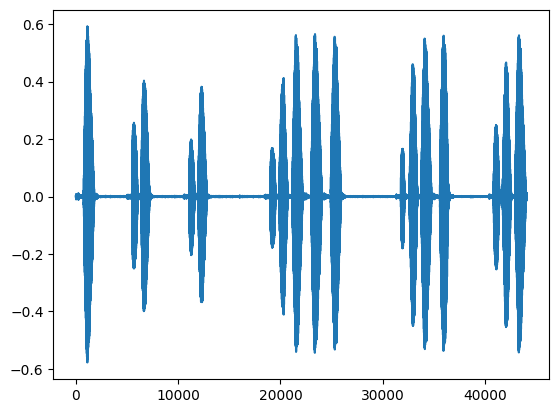

In [6]:
# First segment of signal1
plt.plot(signal1[441000:485100])

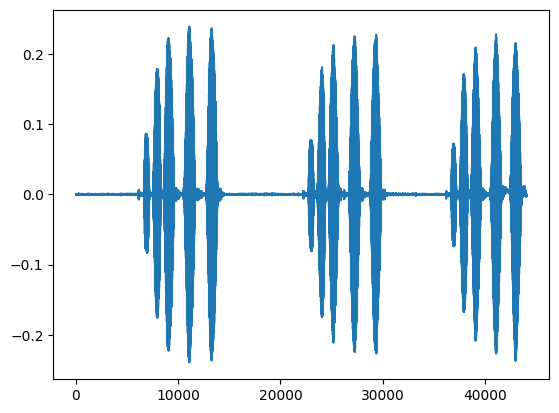

In [7]:
# Last segment of signal2
plt.plot(signal2[3607380:3651480])